# Final Project: Overview

# Objective

The objective of this project is for you to demonstrate your mastery of the Machine Learning process
**using Neural Networks**.



# Submission requirements

The guidelines will be similar to the Midterm
- you will write a procedure that takes raw data and produces predictions

You will submit a *single* model for evaluation.

**Demonstrate that all cells in your notebook work**

The final cell in your notebook should print the message "Done"
- `print("Done")`
- If we run your notebook and this last cell does not execute your submission will be inadequate

## Testing

*You must perform out of sample testing*.

If you want to perform cross-validation in training, that is fine, but you
must *also* test out of sample to show that you are not over-fitting.

It is up to you to create the out of sample data that you feel best evaluates your model.

We will create holdout data (that we will not show you) for grading.

The procedure you write to make predictions should be able to work on the unseen holdout data
(similar to how it should work for your test set but the holdout set has *no targets*)

    

# The data

Data will be provided to you 
- as multiple files in a directory which we refer to as a *data directory*

The reason for this is that the different files may convey different information.

You will be responsible for deciding
- which files to use
- which fields within the files to use

We will give you a data directory for training.

# Submission guidelines

Here are the basics, a code template that you must complete is in the following cells
- you will be required to store  your model in a file
- you will be required to write a procedure `MyModel` that takes two arguments
    - `test_dir`
        - this is a *relative path* to the holdout data directory
    - `model_save_file`
        - this is a *relative path* to the file containing your model
- the holdout data directory is similar in structure to the training data directory
    - but without target labels !  It is your job to predict these.
- your procedure must produce predictions given this holdout data directory

This means that your procedure must
- prepare the files in the holdout data directory similar to the way that they were prepared in the training data directory

We will provide you with a sample data directory that will resemble the holdout -- this is so that you
may test the procedure you write for submission.



## Detailed submission guidelines


In **addition to your notebook that trains/evaluates your model**, 
- please also submit the file that contains your trained model.
    - use `saveModel` to put your final, trained model in this file
- We will **not** train your model; we will only use the method `MyModel`
    - which **you** will implement
    - and which uses `loadModel` and the name of the file in which the model was saved
    - this will create the model that we will evaluate


Here is a code template for you to complete
- it will save your model (assuming it is in variable `my_model`)
- it provides the specification for procedure `MyModel`, which *you must complete*


## Evaluate your model on the holdout data directory

**You must run the following cell** from the directory that contains your model file

Here is how we will evaluate your submission
- we will create a directory whose only content is
    - sub-directory `Data`
- we will restore your model from the saved file`
- we will run the cell in your notebook that should be a copy of the one below
    - it calls procedure `MyModel` with the arguments given below
    - your implementation of `MyModel`
        - must successfully load your model file, *given where **we** have place it as described above*
        - must successfully return one prediction for each example in the holdout directory *given where **we** have placed the holdout directory*

In [1]:
pip install numpy==1.23.5

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install nbformat

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


For this project, I’m treating the task as a regression problem. I think it is more appropriate because it actually includes the information from classification (positive or negative return). Predicting the return size (not just the direction) could also be more useful later if needed for error calculation.

I'll start by working only with AAPL data and basic features like past returns and moving averages to build a simple model first. Once that's working, I’ll add more features, maybe from other tickers too, and try different architectures to improve it.

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import re
from statsmodels.graphics.tsaplots import plot_acf
import plotly.graph_objects as go
import plotly.express as px

from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, LSTM, Input, Conv1D, Attention, LayerNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from sklearn.metrics import roc_curve, auc


print("Running TensorFlow version ",tf.__version__)
version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

Running TensorFlow version  2.19.0
Version 2, minor 19


In [6]:
data_dir = os.path.join(".", "Data", "train")
aapl_path = os.path.join(data_dir, f"AAPL.csv")
aapl = pd.read_csv(aapl_path, parse_dates=["Dt"])
aapl.set_index("Dt", inplace=True)
aapl.head()

,Adj Close,Close,Div,Factor,High,Low,Open,Volume
Dt,,,,,,,,
2000-01-03,3.4785,111.938,0.0,1,112.500,101.688,104.8750,133949200
2000-01-04,3.1852,102.500,0.0,1,110.625,101.188,108.2500,128094400
2000-01-05,3.2318,104.000,0.0,1,110.563,103.000,103.7500,194580400
2000-01-06,2.9521,95.000,0.0,1,107.000,95.000,106.1183,191993200
2000-01-07,3.0920,99.500,0.0,1,101.000,95.500,96.5000,115183600


In [7]:
def summarize_ticker(df):
    # Compute additional columns
    df['Return'] = df['Adj Close'].pct_change()
    df['Cumulative_Return'] = (1 + df['Return']).cumprod() - 1

    print(f"Return Statistics ---")
    print(df['Return'].describe())

    print("\nMissing values per column:")
    print(df.isnull().sum())

    print("\nDate range:")
    print(f"Start date: {df.index.min()}")
    print(f"End date: {df.index.max()}")

    print("\nData types:")
    print(df.dtypes)

    print("\nBasic statistics:")
    print(df.describe())

    print("\nTotal number of rows:", len(df))

    print("\nRandom sample of data:")
    print(df.sample(5, random_state=42))

    return None


def plot_ticker(df):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle("Exploratory Data Analysis", fontsize=16)

    # Plot Adj Close
    axes[0, 0].plot(df['Adj Close'])
    axes[0, 0].set_title("Adjusted Close Price")
    axes[0, 0].set_xlabel("Date")
    axes[0, 0].set_ylabel("Price")
    axes[0, 0].grid(True)

    # Plot Daily Returns
    axes[0, 1].plot(df['Return'])
    axes[0, 1].set_title("Daily Returns")
    axes[0, 1].set_xlabel("Date")
    axes[0, 1].set_ylabel("Return")
    axes[0, 1].grid(True)

    # Plot Cumulative Returns
    axes[1, 0].plot(df['Cumulative_Return'])
    axes[1, 0].set_title("Cumulative Returns")
    axes[1, 0].set_xlabel("Date")
    axes[1, 0].set_ylabel("Cumulative Return")
    axes[1, 0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    axes[1, 0].grid(True)

    # Plot Volume
    axes[1, 1].plot(df['Volume'])
    axes[1, 1].set_title("Trading Volume")
    axes[1, 1].set_xlabel("Date")
    axes[1, 1].set_ylabel("Volume")
    axes[1, 1].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def show_autocorrelation(df, lags=30):
    returns = df['Adj Close'].pct_change().dropna()
    plt.figure(figsize=(10, 4))
    plot_acf(returns, lags=lags)
    plt.title("Autocorrelation of Daily Returns")
    plt.tight_layout()
    plt.show()

def plot_rolling_stats(df, window=20):
    df['Rolling_Mean'] = df['Adj Close'].pct_change().dropna().rolling(window).mean()
    df['Rolling_Std'] = df['Adj Close'].pct_change().dropna().rolling(window).std()

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(df['Rolling_Mean'], label='Rolling Mean')
    ax.plot(df['Rolling_Std'], label='Rolling Std (Volatility)')
    ax.set_title(f"{window}-Day Rolling Statistics")
    ax.legend()
    ax.grid(True)
    plt.show()

def plot_monthly_seasonality(df):
    df = df.copy()
    df['Return'] = df['Adj Close'].pct_change()
    df['Month'] = df.index.month
    monthly_returns = df.groupby('Month')['Return'].mean()
    monthly_returns.plot(kind='bar', figsize=(10, 4), title="Average Monthly Return")
    plt.xlabel("Month")
    plt.ylabel("Average Return")
    plt.grid(True)
    plt.show()


def plot_weekday_seasonality(df):
    df = df.copy()
    df['Return'] = df['Adj Close'].pct_change()
    df['Weekday'] = df.index.day_name()
    weekday_returns = df.groupby('Weekday')['Return'].mean().reindex(
        ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    )
    weekday_returns.plot(kind='bar', figsize=(10, 4), title="Average Return by Weekday")
    plt.xlabel("Weekday")
    plt.ylabel("Average Return")
    plt.grid(True)
    plt.show()

def candle_stick(df, stock):
    fig = go.Figure(data=[go.Candlestick(x=df.index,
                    open=df['Open'],
                    high=df['High'],
                    low=df['Low'],
                    close=df['Close'])])


    fig.update_layout(title = {'text' : f"{stock}'s price by period",
                               'x':0.5,
                               'xanchor' : 'center'},
                    xaxis_title = 'Period slicer',
                    yaxis_title = 'Price',
                    template = 'plotly_dark',  
                    xaxis_rangeslider_visible=True,
                    width=1100, height=600)
    fig.show()


I am taking adjusted close prices to account for multiple stock splits AAPL had durng the testing period.

In [8]:
ticker = 'AAPL'
summarize_ticker(aapl)

Return Statistics ---
count    4276.000000
mean        0.001186
std         0.026760
min        -0.518677
25%        -0.011262
50%         0.000806
75%         0.013808
max         0.139042
Name: Return, dtype: float64

Missing values per column:
Adj Close            0
Close                0
Div                  0
Factor               0
High                 0
Low                  0
Open                 0
Volume               0
Return               1
Cumulative_Return    1
dtype: int64

Date range:
Start date: 2000-01-03 00:00:00
End date: 2016-12-30 00:00:00

Data types:
Adj Close            float64
Close                float64
Div                  float64
Factor                 int64
High                 float64
Low                  float64
Open                 float64
Volume                 int64
Return               float64
Cumulative_Return    float64
dtype: object

Basic statistics:
         Adj Close        Close          Div       Factor         High  \
count  4277.000000  4277.

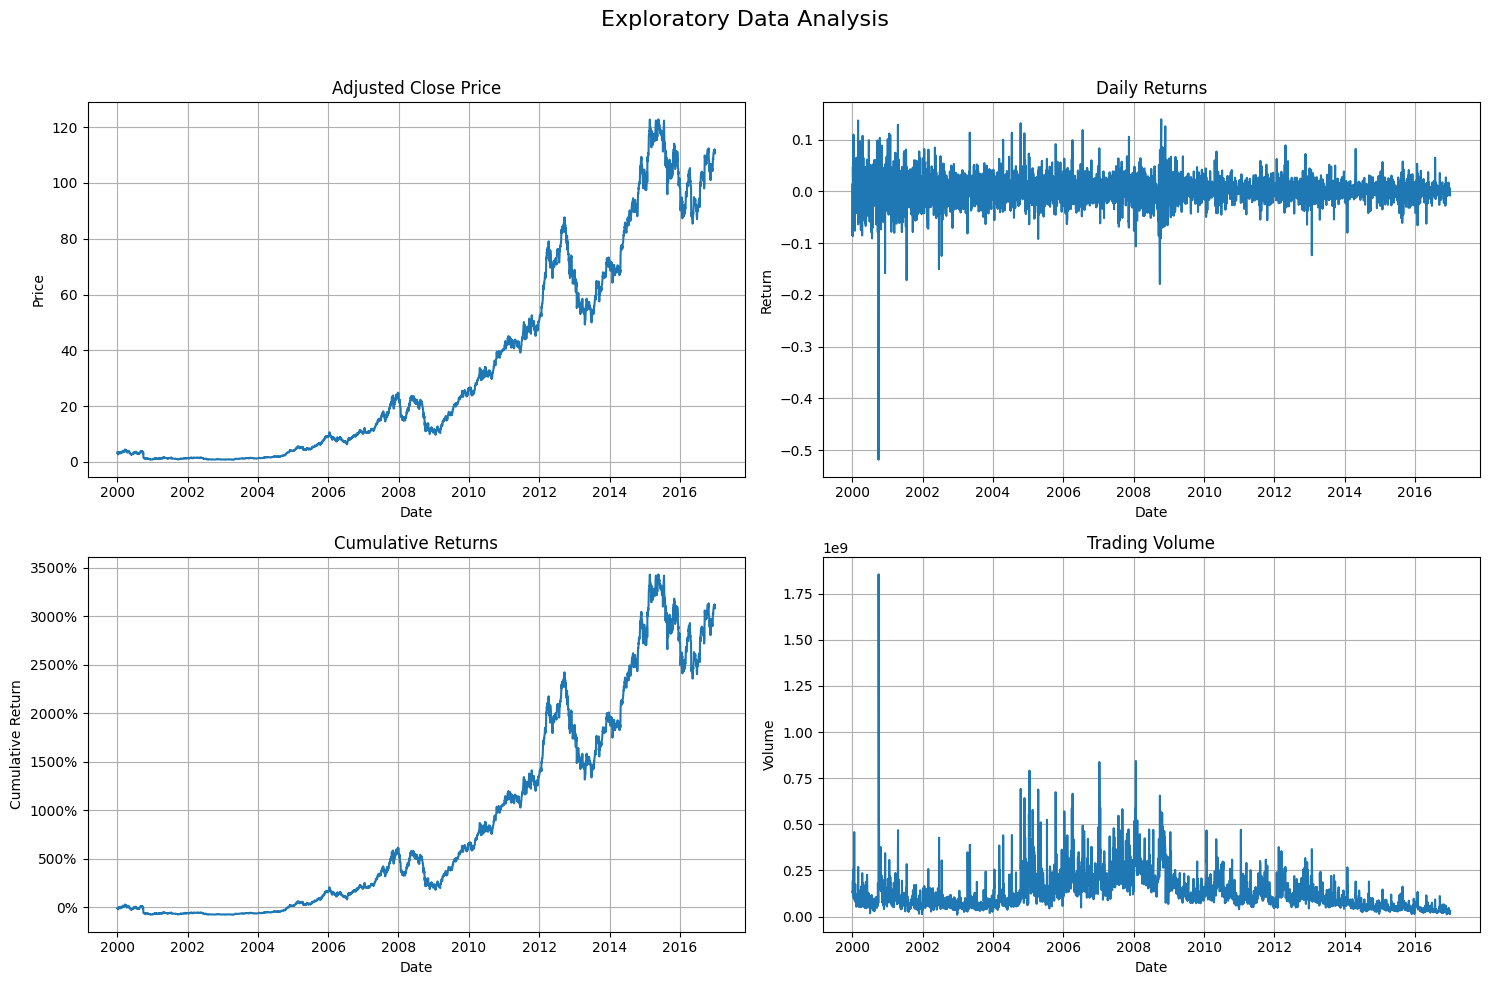

In [9]:
plot_ticker(aapl)

<Figure size 1000x400 with 0 Axes>

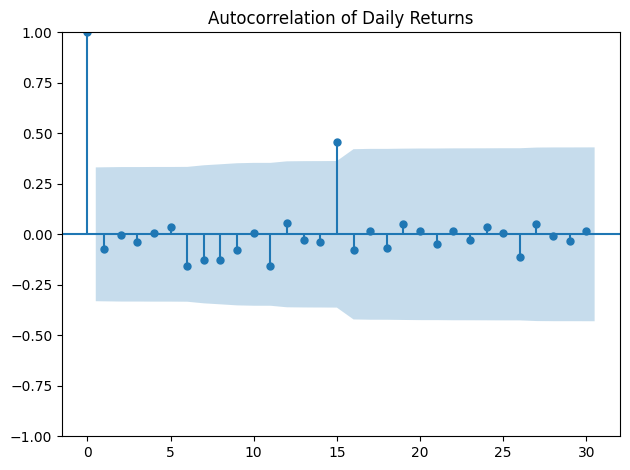

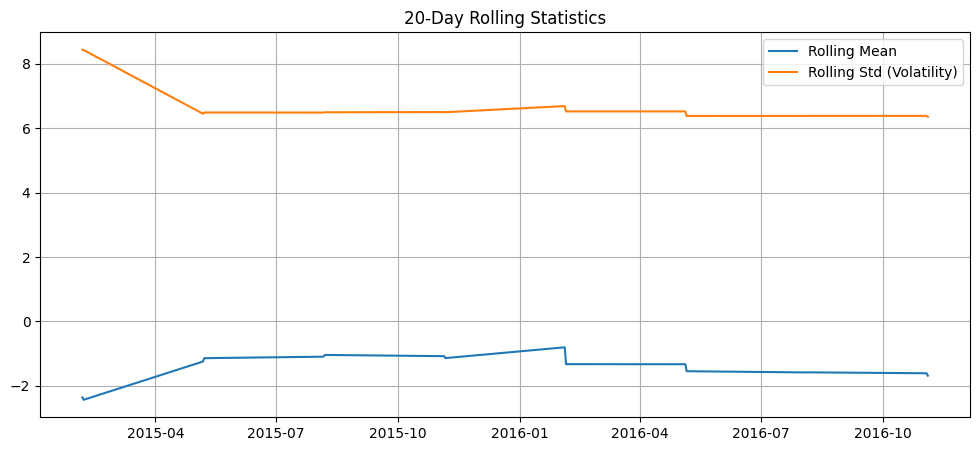

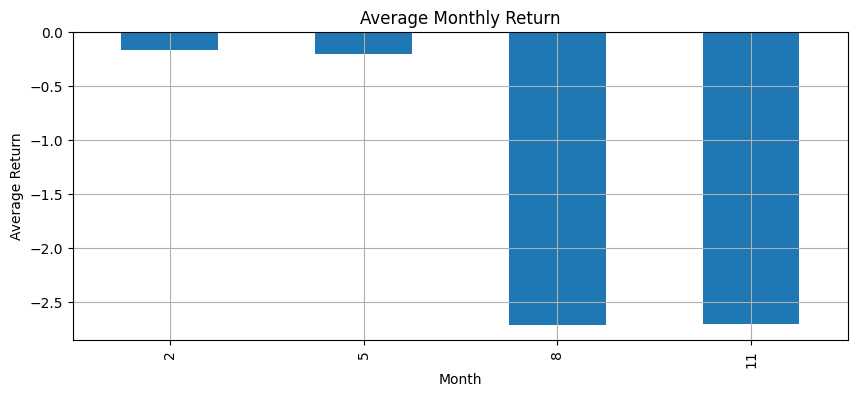

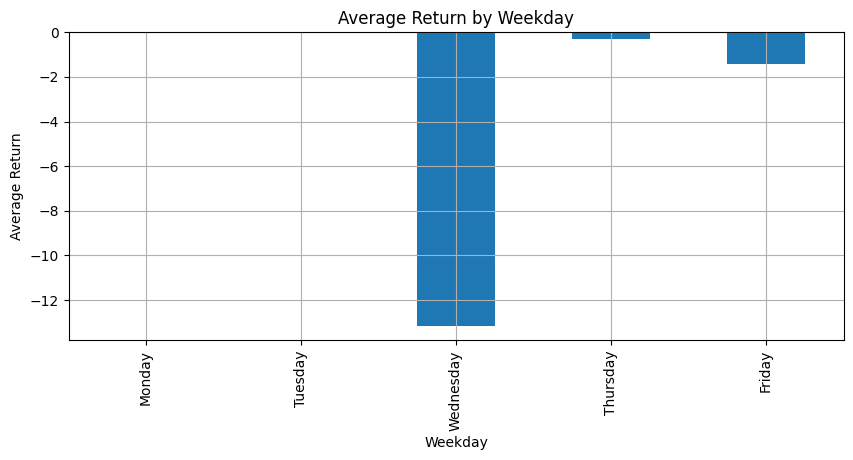

In [10]:
aapl_returns = aapl.pct_change().dropna()
show_autocorrelation(aapl_returns)
plot_rolling_stats(aapl_returns)
plot_monthly_seasonality(aapl_returns)
plot_weekday_seasonality(aapl_returns)

In [11]:
candle_stick(aapl,'AAPL')

## Feature engineering

In [12]:
# 1. Rolling standardization function (so we don't peek into future)
def rolling_standardize(series, window=30):
    rolling_mean = series.shift(1).rolling(window=window, min_periods=1).mean()
    rolling_std = series.shift(1).rolling(window=window, min_periods=1).std()
    standardized = (series - rolling_mean) / rolling_std
    return standardized

In [13]:
def extract_features(df, window=30):
    df = df.copy()
    
    # Adj Close price returns
    df['adj_close_ret'] = df['Adj Close'].pct_change()
    
    # Standardized Adj Close returns
    rolling_mean = df['adj_close_ret'].shift(1).rolling(window=window, min_periods=window).mean()
    rolling_std = df['adj_close_ret'].shift(1).rolling(window=window, min_periods=window).std()
    df['adj_close_ret_st'] = (df['adj_close_ret'] - rolling_mean) / rolling_std
    
    # High - Low price
    df['high_low'] = df['High'] - df['Low']
    
    # Log volume
    df['log_volume'] = np.log(df['Volume'].replace(0, np.nan))
    
    # Return only the selected columns
    return df[['Adj Close','adj_close_ret', 'adj_close_ret_st', 'High','Low','high_low', 'log_volume']]

aapl_fe = extract_features(aapl)
aapl_fe

,Adj Close,adj_close_ret,adj_close_ret_st,High,Low,high_low,log_volume
Dt,,,,,,,
2000-01-03,3.4785,NaN,NaN,112.5000,101.688,10.8120,18.712971
2000-01-04,3.1852,-0.084318,NaN,110.6250,101.188,9.4370,18.668278
2000-01-05,3.2318,0.014630,NaN,110.5630,103.000,7.5630,19.086356
2000-01-06,2.9521,-0.086546,NaN,107.0000,95.000,12.0000,19.072971
2000-01-07,3.0920,0.047390,NaN,101.0000,95.500,5.5000,18.562038
...,...,...,...,...,...,...,...
2016-12-23,111.3073,0.001978,0.028842,116.5255,115.590,0.9355,16.472232
2016-12-27,112.0142,0.006351,0.376098,117.8000,116.490,1.3100,16.722242
2016-12-28,111.5366,-0.004264,-0.702507,118.0170,116.200,1.8170,16.855542


##### I am going to add some of the most important technical indicators, such as simple moving averages (SMA) and exponential moving averages (EMA) to capture trends over different periods. I’m also adding RSI, which shows if the stock is overbought or oversold, and MACD, which looks at momentum by comparing two EMAs. I included Bollinger Bands to measure volatility (how much price moves around the average). I’m also adding the stochastic oscillator, which looks at where the close price is compared to the recent high and low, and ATR, which measures how much the stock usually moves day-to-day. 

##### I won't be using these in the beginning for simpler models,but I will add them later in more complex models.

##### All of these are built using only past data up to day (t-1), so there’s no future leak. Altogether they should give a good mix of trend, momentum, and volatility signals for the model.

In [14]:
def add_technical_indicators(df, price_col='Adj Close'):
    df = df.copy()
    price = df[price_col]

    # SMA & EMA
    for window in [5, 10, 20, 50]:
        df[f'SMA_{window}'] = price.rolling(window=window, min_periods=1).mean()
        df[f'EMA_{window}'] = price.ewm(span=window, adjust=False).mean()

    # RSI
    delta = price.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14, min_periods=1).mean()
    avg_loss = loss.rolling(window=14, min_periods=1).mean()
    rs = avg_gain / avg_loss
    df['RSI_14'] = 100 - (100 / (1 + rs))

    # Bollinger Bands
    sma_20 = price.rolling(window=20, min_periods=1).mean()
    std_20 = price.rolling(window=20, min_periods=1).std()
    df['Bollinger_Upper'] = sma_20 + 2 * std_20
    df['Bollinger_Lower'] = sma_20 - 2 * std_20

    # MACD
    ema_12 = price.ewm(span=12, adjust=False).mean()
    ema_26 = price.ewm(span=26, adjust=False).mean()
    macd_line = ema_12 - ema_26
    df['MACD_Line'] = macd_line
    df['MACD_Signal'] = macd_line.ewm(span=9, adjust=False).mean()

    # Stochastic Oscillator
    low_min = df['Low'].rolling(window=14, min_periods=1).min()
    high_max = df['High'].rolling(window=14, min_periods=1).max()
    percent_k = 100 * (price - low_min) / (high_max - low_min)
    df['Stoch_%K'] = percent_k
    df['Stoch_%D'] = percent_k.rolling(window=3, min_periods=1).mean()

    # ATR
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - price.shift())
    low_close = np.abs(df['Low'] - price.shift())
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df['ATR_14'] = true_range.rolling(window=14, min_periods=1).mean()

    return df


In [15]:
aapl_fe = add_technical_indicators(aapl_fe)
aapl_fe

,Adj Close,adj_close_ret,adj_close_ret_st,High,Low,high_low,log_volume,SMA_5,EMA_5,SMA_10,...,SMA_50,EMA_50,RSI_14,Bollinger_Upper,Bollinger_Lower,MACD_Line,MACD_Signal,Stoch_%K,Stoch_%D,ATR_14
Dt,,,,,,,,,,,,,,,,,,,,,
2000-01-03,3.4785,NaN,NaN,112.5000,101.688,10.8120,18.712971,3.47850,3.478500,3.47850,...,3.478500,3.478500,NaN,NaN,NaN,0.000000,0.000000,-908.337958,-908.337958,10.812000
2000-01-04,3.1852,-0.084318,NaN,110.6250,101.188,9.4370,18.668278,3.33185,3.380733,3.33185,...,3.331850,3.466998,0.000000,3.746639,2.917061,-0.023397,-0.004679,-866.361386,-887.349672,58.979250
2000-01-05,3.2318,0.014630,NaN,110.5630,103.000,7.5630,19.086356,3.29850,3.331089,3.29850,...,3.298500,3.457775,13.709915,3.613733,2.983267,-0.037744,-0.011292,-865.949434,-880.216259,75.112100
2000-01-06,2.9521,-0.086546,NaN,107.0000,95.000,12.0000,19.072971,3.21190,3.204759,3.21190,...,3.211900,3.437944,7.520981,3.643456,2.780344,-0.070867,-0.023207,-525.988000,-752.766273,82.276125
2000-01-07,3.0920,0.047390,NaN,101.0000,95.500,5.5000,18.562038,3.18792,3.167173,3.18792,...,3.187920,3.424378,24.555629,3.576740,2.799100,-0.084850,-0.035536,-525.188571,-639.042002,85.430480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,111.3073,0.001978,0.028842,116.5255,115.590,0.9355,16.472232,111.47162,111.196223,110.70836,...,107.679352,107.570789,86.146147,113.772329,102.884321,1.452375,1.075025,25.747002,31.684316,6.234743
2016-12-27,112.0142,0.006351,0.376098,117.8000,116.490,1.3100,16.722242,111.59008,111.468882,111.08664,...,107.683762,107.745040,86.009695,114.216317,102.983873,1.495308,1.159081,33.034722,29.819494,6.260564
2016-12-28,111.5366,-0.004264,-0.702507,118.0170,116.200,1.8170,16.855542,111.55378,111.491455,111.23662,...,107.680140,107.893729,79.937431,114.522067,103.184413,1.473805,1.222026,12.627747,23.803157,6.249421


Now I am going to check if there is high dependency among features. 

In [16]:
def plot_correlation_matrix(df):
    corr = df.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, cmap='coolwarm', annot=False, fmt=".2f", center=0)
    plt.title("Feature Correlation Matrix")
    plt.show()


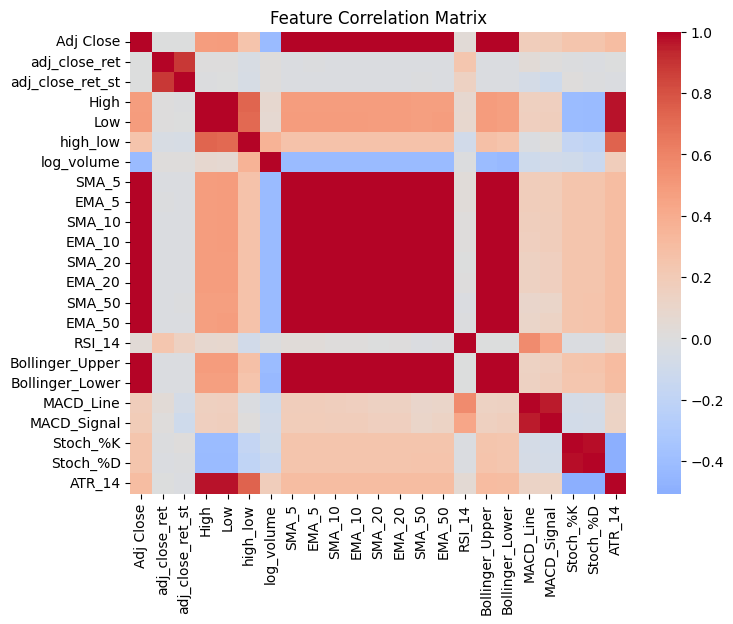

In [17]:
plot_correlation_matrix(aapl_fe)

The features which are highly correlated with each other are actually supposed to be highly correlated, moving averages for example, so I am not going to drop them and I'll let neural networks learn the patterns using all of them.

##### Model architecture and performance plotting functions. I am using plotly, which looks more decent.

In [18]:
def plotTrainLoss(history):
    fig = go.Figure()
    fig.add_trace(go.Scatter(y = history.history['val_loss'], mode = 'lines', name = 'test_loss'))
    fig.add_trace(go.Scatter(y = history.history['loss'], mode = 'lines',name = 'train_loss'))
    fig.update_layout(
                    width=1000,
                    height=500)
    fig.show()

import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plotTrain(history):
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Accuracy", "Loss"))

    # Accuracy
    fig.add_trace(go.Scatter(
        y=history.history['accuracy'], mode='lines+markers', name='Train Accuracy'
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        y=history.history['val_accuracy'], mode='lines+markers', name='Validation Accuracy'
    ), row=1, col=1)

    # Loss
    fig.add_trace(go.Scatter(
        y=history.history['loss'], mode='lines+markers', name='Train Loss'
    ), row=1, col=2)

    fig.add_trace(go.Scatter(
        y=history.history['val_loss'], mode='lines+markers', name='Validation Loss'
    ), row=1, col=2)

    fig.update_layout(
        title_text='Training and Validation Metrics',
        width=1000,
        height=500,
        showlegend=True
    )

    fig.show()


# Feedforward fully connected NN

First I will try simple neural network, which simply takes adjusted close return series (standardized) and outputs the next day's return forecast.

In [19]:
def create_sequences(series, window_size):
    
    X = []
    y = []
    
    for i in range(window_size, len(series)):
        X.append(series[i-window_size:i].values.reshape(-1, 1))
        y.append(series[i])
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y


In [20]:
window_size = 30

# Create sequences
series = aapl_fe['adj_close_ret']
series = series.reset_index(drop=True)
X, y = create_sequences(series, window_size)

# Split into train and validation
split_idx = int(len(X) * 0.8)  # 80% train, 20% validation

X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

input_shape = X_train.shape[1:]  # Should be (30, 1)

# Create a Sequential model
model0 = Sequential([
    Flatten(input_shape=input_shape),  # Flatten the (30,1) input into (30,)
    Dense(64, activation='relu', name='dense_hidden_1'),  # First dense hidden layer
    Dense(32, activation='relu', name='dense_hidden_2'),  # Second dense hidden layer
    Dropout(0.2, name='dropout'),  # Dropout to prevent overfitting
    Dense(1, activation='linear', name='output')  # Output layer: one number (next day's return)
])

# Compile the model
model0.compile(optimizer='adam', loss='mse')

# Display the model summary
model0.summary()

# Plot the model structure (optional, but nice)
plot_model(model0, show_shapes=True, show_layer_names=True,dpi=70);

c:\Users\gigan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden_1 (Dense)          │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden_2 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,097 (16.00 KB)

 Trainable params: 4,097 (16.00 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history0 = model0.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

plotTrainLoss(history0)

Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 9.0086e-04 - val_loss: 2.2864e-04
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.5363e-04 - val_loss: 2.2826e-04
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.5765e-04 - val_loss: 2.3661e-04
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.8573e-04 - val_loss: 2.2810e-04
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.9318e-04 - val_loss: 2.2717e-04
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.4162e-04 - val_loss: 2.2760e-04
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.6585e-04 - val_loss: 2.3342e-04
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.7429e-04 - val_loss: 2.3220e-04
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.4447e-04 - val_loss: 2.2697e-04
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.7927e-04 - val_loss: 2.2972e-04


Training loss is higher than validation loss, which I think might be because of dropout layer which is applied only during training. The validation pass runs with full network capacity, often yielding better performance.

But the validation loss is not exactly decreasing as we move through the epochs, so let's add more layers with more features. But to be honest I won't try focusing too much on this type of basic NNs because they are not that appropriate for time series data anyway.

In [22]:
model1 = Sequential([
    Flatten(input_shape=input_shape),
    Dense(128, activation='gelu', name='dense_hidden_1'),
    Dense(64, activation='gelu', name='dense_hidden_2'),
    Dense(32, activation='gelu', name='dense_hidden_3'),
    Dropout(0.3, name='dropout'),
    Dense(1, activation='linear', name='output')  # Output: next day's return
])

# Compile model with smaller learning rate
optimizer = Adam(learning_rate=0.0005)
model1.compile(optimizer=optimizer, loss='mse')

# Print model summary
model1.summary()

# Plot model diagram (optional, but nice)
plot_model(model1, show_shapes=True, dpi=70)

# Set early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True);

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden_1 (Dense)          │ (None, 128)            │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden_2 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden_3 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,337 (56.00 KB)

 Trainable params: 14,337 (56.00 KB)

 Non-trainable params: 0 (0.00 B)

Here I tried GeLu activation function instead of ReLu.

In [23]:
history1 = model1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,          # Train long, stop early if needed
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

plotTrainLoss(history1)

Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: nan - val_loss: nan
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: nan - val_loss: nan
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: nan - val_loss: nan
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: nan - val_loss: nan
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: nan - val_loss: nan
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: nan - val_loss: nan
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: nan - val_loss: nan
Epoch 8/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: nan - val_loss: nan


The model is not learning very well, the validation loss is not decreasing. There might be several reasons for it, the most important of which might be that the returns data is noisy and does not inlucde any real signal. Also this is a poor model architecture for this type of analysis. 

In [24]:
def create_multifeature_sequences(df, feature_columns, window_size):

    X = []
    y = []
    features = df[feature_columns].dropna().reset_index(drop=True)
    target = df['adj_close_ret'].dropna().reset_index(drop=True)  # target is still next day return

    for i in range(window_size, len(features)):
        X.append(features.iloc[i-window_size:i].values)  # (window_size, num_features)
        y.append(target.iloc[i])  # predict next day's return

    X = np.array(X)
    y = np.array(y)
    
    return X, y


In [25]:
window_size = 30

feature_columns = aapl_fe.columns.to_list()
X, y = create_multifeature_sequences(aapl_fe, feature_columns, window_size)

split_idx = int(len(X) * 0.8)

X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

input_shape = X_train.shape[1:]
input_shape

(30, 23)

# RNN

Let's start with simple RNN

In [26]:
model3 = Sequential([
    SimpleRNN(32, activation='tanh', input_shape=input_shape),
    Dense(16, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='linear')
])

model3.compile(optimizer='adam', loss='mse')

# Model summary
model3.summary()

# Plot model
plot_model(model3, show_shapes=True, dpi=70);

c:\Users\gigan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,337 (9.13 KB)

 Trainable params: 2,337 (9.13 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history3 = model3.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

plotTrainLoss(history3)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.1037 - val_loss: 0.2425
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0139 - val_loss: 0.1497
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0038 - val_loss: 0.1287
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0023 - val_loss: 0.1180
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022 - val_loss: 0.1388
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0013 - val_loss: 0.1217
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0012 - val_loss: 0.0415
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011 - val_loss: 0.0421
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.3412e-04 - val_loss: 0.0405
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.9802e-04 - val_loss: 0.0395
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.5182e-04 - val_loss: 0.0400
Epoch 12/100
106/1

#### Now I'm gonna switch to a deeper RNN model by adding a second SimpleRNN layer. The first one returns the full sequence, so the second can learn more complex patterns over time. This should help capture better temporal dependencies than the single-layer version.

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 30, 64)         │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,769 (34.25 KB)

 Trainable params: 8,769 (34.25 KB)

 Non-trainable params: 0 (0.00 B)

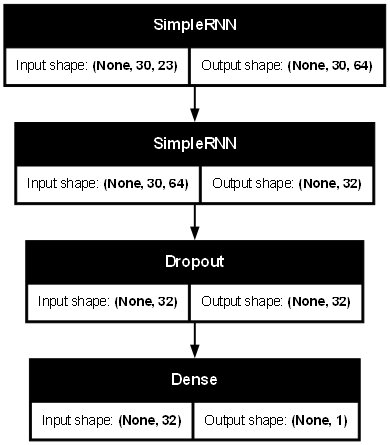

In [28]:
model4 = Sequential([
    SimpleRNN(64, activation='tanh', input_shape=input_shape, return_sequences=True),
    SimpleRNN(32, activation='tanh'),  # second RNN layer
    # Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='linear')
])

model4.compile(optimizer='adam', loss='mse')

# Model summary
model4.summary()

# Optional: Plot model structure
plot_model(model4, show_shapes=True, dpi=70)

In [29]:
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history4 = model4.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

plotTrainLoss(history4)

Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.1297 - val_loss: 0.0637
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0690 - val_loss: 0.0508
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0321 - val_loss: 0.0369
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0198 - val_loss: 0.0299
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0141 - val_loss: 0.0314
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0095 - val_loss: 0.0441
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0079 - val_loss: 0.0471
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0060 - val_loss: 0.0365
Epoch 9/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0051 - val_loss: 0.0299
Epoch 10/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0037 - val_loss: 0.0291


RNN performs obviously way better, which is expected because this model specification is designed to learn from sequential feature space like time series, as opposed to regular NNs or CNNs which are not built for this task.

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)        │ (None, 30, 128)        │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,545 (142.75 KB)

 Trainable params: 36,289 (141.75 KB)

 Non-trainable params: 256 (1.00 KB)

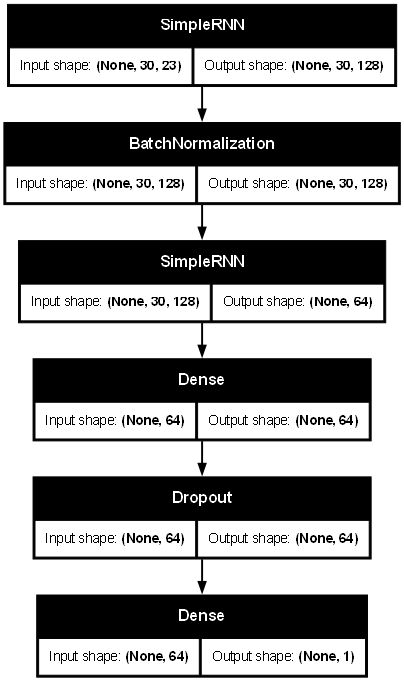

In [30]:
model5 = Sequential([
    SimpleRNN(128, activation='tanh', return_sequences=True, input_shape=input_shape),
    BatchNormalization(),
    SimpleRNN(64, activation='tanh'),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='linear')
])

# Compile with lower learning rate
optimizer = Adam(learning_rate=0.0003)
model5.compile(optimizer=optimizer, loss='mse')

# Summary
model5.summary()

# Optional plot
plot_model(model5, show_shapes=True, dpi=70)

In [31]:
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history5 = model5.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

plotTrainLoss(history5)

Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.2726 - val_loss: 0.1216
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0958 - val_loss: 0.1276
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0573 - val_loss: 0.1224
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0400 - val_loss: 0.0632
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0226 - val_loss: 0.0456
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0142 - val_loss: 0.0443
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0098 - val_loss: 0.0303
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0089 - val_loss: 0.0282
Epoch 9/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0054 - val_loss: 0.0237
Epoch 10/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0044 - val_loss: 0.0198


Validation loss is actually increasing here even as training loss decreases, so experimenting with larger and deeper SimpleRNN models does not help apparently. I think I may have overcomplicated the model, making it too large relative to the amount and quality of information available. So the model was memorizing noise in the training set rather than learning patterns that generalize to new data. 

To address this, I will simplify the model architecture, add stronger regularization (higher dropout), lower the learning rate for more careful updates, and shift the task slightly: instead of predicting the exact next-day return, I will predict the direction (up or down). Predicting direction should be more stable and achievable, given the noisy nature of financial return data.

Here I use learning_rate=0.0001 as the optimizer because it adapts the learning rate during training and generally converges faster and more reliably than SGD. I chose a small learning rate to ensure stable updates and avoid overshooting. I also use dropout layers to control for overfitting.

In [32]:
y_binary = (y > 0).astype(int)

# Split again for binary target
split_idx = int(len(X) * 0.8)
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y_binary[:split_idx], y_binary[split_idx:]

# Build model
input_shape = X_train.shape[1:]

model6 = Sequential([
    SimpleRNN(64, activation='tanh', input_shape=input_shape, return_sequences=True),
    Dropout(0.2),
    SimpleRNN(32, activation='tanh'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.0001)
model6.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Summary
model6.summary()

# Plot model
plot_model(model6, show_shapes=True, dpi=70)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train
history6 = model6.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

plotTrain(history6)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_5 (SimpleRNN)        │ (None, 30, 64)         │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,769 (34.25 KB)

 Trainable params: 8,769 (34.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.4986 - loss: 0.8364 - val_accuracy: 0.4905 - val_loss: 0.7157
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.4957 - loss: 0.7751 - val_accuracy: 0.5071 - val_loss: 0.7181
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5013 - loss: 0.7577 - val_accuracy: 0.5012 - val_loss: 0.7168
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5048 - loss: 0.7505 - val_accuracy: 0.5059 - val_loss: 0.7118
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5216 - loss: 0.7487 - val_accuracy: 0.5071 - val_loss: 0.7133
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5145 - loss: 0.7421 - val_accuracy: 0.5000 - val_loss: 0.7145
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5128 - loss: 0.7374 - val_accuracy: 0.5237 - val_loss: 0.7090
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.4982 - loss: 0.7517 - val_accu

Well I simplified the model and used binary classification, which actually has decreasing losses on both training and validation part, but it actually does not perform better than random 50-50 classification (because accuracy is around 50%). So now I'll move on to LTSM.

Also I will add 2 variables that might be interesting: lagged_15 return (because as we saw in autocorrelation graph, the return series has siginificant dependency on 15th day lagged return) and the variable is_wednesday (because average weekly returnsgraph showed that there is significant negative average return on that day).

In [33]:
def add_custom_features(df):
    df = df.copy()
    df['lagged_15_ret'] = df['adj_close_ret'].shift(15)
    df['is_wednesday'] = (df.index.dayofweek == 2).astype(int)
    return df

aapl_fe = add_custom_features(aapl_fe)
aapl_fe

,Adj Close,adj_close_ret,adj_close_ret_st,High,Low,high_low,log_volume,SMA_5,EMA_5,SMA_10,...,RSI_14,Bollinger_Upper,Bollinger_Lower,MACD_Line,MACD_Signal,Stoch_%K,Stoch_%D,ATR_14,lagged_15_ret,is_wednesday
Dt,,,,,,,,,,,,,,,,,,,,,
2000-01-03,3.4785,NaN,NaN,112.5000,101.688,10.8120,18.712971,3.47850,3.478500,3.47850,...,NaN,NaN,NaN,0.000000,0.000000,-908.337958,-908.337958,10.812000,NaN,0
2000-01-04,3.1852,-0.084318,NaN,110.6250,101.188,9.4370,18.668278,3.33185,3.380733,3.33185,...,0.000000,3.746639,2.917061,-0.023397,-0.004679,-866.361386,-887.349672,58.979250,NaN,0
2000-01-05,3.2318,0.014630,NaN,110.5630,103.000,7.5630,19.086356,3.29850,3.331089,3.29850,...,13.709915,3.613733,2.983267,-0.037744,-0.011292,-865.949434,-880.216259,75.112100,NaN,1
2000-01-06,2.9521,-0.086546,NaN,107.0000,95.000,12.0000,19.072971,3.21190,3.204759,3.21190,...,7.520981,3.643456,2.780344,-0.070867,-0.023207,-525.988000,-752.766273,82.276125,NaN,0
2000-01-07,3.0920,0.047390,NaN,101.0000,95.500,5.5000,18.562038,3.18792,3.167173,3.18792,...,24.555629,3.576740,2.799100,-0.084850,-0.035536,-525.188571,-639.042002,85.430480,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,111.3073,0.001978,0.028842,116.5255,115.590,0.9355,16.472232,111.47162,111.196223,110.70836,...,86.146147,113.772329,102.884321,1.452375,1.075025,25.747002,31.684316,6.234743,0.003745,0
2016-12-27,112.0142,0.006351,0.376098,117.8000,116.490,1.3100,16.722242,111.59008,111.468882,111.08664,...,86.009695,114.216317,102.983873,1.495308,1.159081,33.034722,29.819494,6.260564,-0.007189,0
2016-12-28,111.5366,-0.004264,-0.702507,118.0170,116.200,1.8170,16.855542,111.55378,111.491455,111.23662,...,79.937431,114.522067,103.184413,1.473805,1.222026,12.627747,23.803157,6.249421,0.007698,1


Also I will be using 60-day window here. Maybe there is some information farther in the past that the 30-day window is missing.

# LSTM

In [34]:
window_size = 60

feature_columns = aapl_fe.columns.to_list()
X, y = create_multifeature_sequences(aapl_fe, feature_columns, window_size)

y_binary = (y > 0).astype(int)

# Split again for binary target
split_idx = int(len(X) * 0.8)
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y_binary[:split_idx], y_binary[split_idx:]

# Build model
input_shape = X_train.shape[1:]

model7 = Sequential([
    LSTM(32, activation='tanh', input_shape=input_shape, return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile
optimizer = Adam(learning_rate=0.0007)  # Little faster learning rate since LSTM can stabilize better
model7.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Summary
model7.summary()

# Plot
plot_model(model7, show_shapes=True, dpi=70)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train
history7 = model7.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Plot
plotTrain(history7)

c:\Users\gigan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 32)         │         7,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 60, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,833 (65.75 KB)

 Trainable params: 16,833 (65.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 16s 79ms/step - accuracy: 0.5054 - loss: 0.6963 - val_accuracy: 0.5072 - val_loss: 0.6956
Epoch 2/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.5066 - loss: 0.6958 - val_accuracy: 0.5131 - val_loss: 0.6943
Epoch 3/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.5238 - loss: 0.6924 - val_accuracy: 0.5107 - val_loss: 0.6942
Epoch 4/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.5066 - loss: 0.6932 - val_accuracy: 0.4952 - val_loss: 0.6947
Epoch 5/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.5175 - loss: 0.6923 - val_accuracy: 0.4821 - val_loss: 0.6959
Epoch 6/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.5210 - loss: 0.6923 - val_accuracy: 0.5024 - val_loss: 0.6934
Epoch 7/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.5282 - loss: 0.6919 - val_accuracy: 0.4988 - val_loss: 0.6956
Epoch 8/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.5292 - loss: 0.6897 - val_acc

It does not look good. Both accuracy and losses are all over the place. 

##### I am going to add SPY and MSFT returns to the features, because the broader market and peer returns might be indicative of what might stock do the next day.

In [35]:
def add_peer_returns(aapl_df, dir):
    def load_adj_close_return(ticker):
        path = os.path.join(dir, f"{ticker}.csv")
        df = pd.read_csv(path, parse_dates=['Dt']).set_index('Dt')
        return df['Adj Close'].pct_change()

    aapl_df = aapl_df.copy()
    aapl_df['SPY_ret'] = load_adj_close_return("SPY").reindex(aapl_df.index)
    aapl_df['MSFT_ret'] = load_adj_close_return("MSFT").reindex(aapl_df.index)

    aapl_df = aapl_df.dropna()

    aapl_df = aapl_df.drop(columns=[col for col in ['High', 'Low'] if col in aapl_df.columns])

    return aapl_df

aapl_fe = add_peer_returns(aapl_fe,data_dir)
aapl_fe

,Adj Close,adj_close_ret,adj_close_ret_st,high_low,log_volume,SMA_5,EMA_5,SMA_10,EMA_10,SMA_20,...,Bollinger_Lower,MACD_Line,MACD_Signal,Stoch_%K,Stoch_%D,ATR_14,lagged_15_ret,is_wednesday,SPY_ret,MSFT_ret
Dt,,,,,,,,,,,,,,,,,,,,,
2000-02-16,3.5464,-0.040969,-0.893843,6.0000,18.364762,3.54992,3.556888,3.49301,3.495297,3.405815,...,3.056320,0.075238,0.041406,-357.512353,-372.051812,108.442364,-0.018376,1,-0.014730,-0.009509
2000-02-17,3.5697,0.006570,0.040112,2.3750,18.097363,3.55846,3.561159,3.52894,3.508825,3.407950,...,3.054835,0.077218,0.048568,-357.420765,-357.283318,108.763571,-0.001694,0,-0.005172,0.020485
2000-02-18,3.4571,-0.031543,-0.759101,4.5000,17.882148,3.57400,3.526473,3.53904,3.499420,3.407855,...,3.054797,0.068907,0.052636,-407.807568,-374.246895,109.555593,-0.076149,0,-0.021468,-0.045798
2000-02-22,3.5367,0.023025,0.375653,10.2500,18.474923,3.56156,3.529882,3.53826,3.506198,3.419605,...,3.065782,0.067960,0.055701,-407.460546,-390.896293,110.391657,0.020899,0,-0.002541,-0.013147
2000-02-23,3.6125,0.021432,0.362700,8.0000,18.588521,3.54448,3.557421,3.54254,3.525526,3.425820,...,3.062679,0.072490,0.059059,-490.844677,-435.370930,111.566914,-0.033716,1,0.011808,0.004663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,111.3073,0.001978,0.028842,0.9355,16.472232,111.47162,111.196223,110.70836,110.446019,108.328325,...,102.884321,1.452375,1.075025,25.747002,31.684316,6.234743,0.003745,0,0.001464,-0.004878
2016-12-27,112.0142,0.006351,0.376098,1.3100,16.722242,111.59008,111.468882,111.08664,110.731143,108.600095,...,102.983873,1.495308,1.159081,33.034722,29.819494,6.260564,-0.007189,0,0.002481,0.000632
2016-12-28,111.5366,-0.004264,-0.702507,1.8170,16.855542,111.55378,111.491455,111.23662,110.877590,108.853240,...,103.184413,1.473805,1.222026,12.627747,23.803157,6.249421,0.007698,1,-0.008265,-0.004583


In [36]:
model8 = Sequential([
    LSTM(64, activation='tanh', input_shape=input_shape, return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    # Dropout(0.2),
    # Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile
optimizer = Adam(learning_rate=0.0005)  # Little faster learning rate since LSTM can stabilize better
model8.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy',AUC(name='auc')])

y_val_pred_prob = model8.predict(X_val).ravel()  # Flatten to 1D array

# Summary
model8.summary()

# Plot
plot_model(model8, show_shapes=True, dpi=70)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
history8 = model8.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# Plot
plotTrain(history8)

c:\Users\gigan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 64)         │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,001 (140.63 KB)

 Trainable params: 36,001 (140.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.5034 - auc: 0.5062 - loss: 0.6973 - val_accuracy: 0.5107 - val_auc: 0.5037 - val_loss: 0.7024
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.5129 - auc: 0.5152 - loss: 0.6944 - val_accuracy: 0.4964 - val_auc: 0.5001 - val_loss: 0.7021
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5283 - auc: 0.5266 - loss: 0.6922 - val_accuracy: 0.4952 - val_auc: 0.5119 - val_loss: 0.7012
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5174 - auc: 0.5241 - loss: 0.6926 - val_accuracy: 0.4988 - val_auc: 0.5043 - val_loss: 0.7010
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5372 - auc: 0.5423 - loss: 0.6898 - val_accuracy: 0.4976 - val_auc: 0.5237 - val_loss: 0.7013
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5277 - auc: 0.5373 - loss: 0.6906 - val_accuracy: 0.4857 - val_auc: 0.5174 - val_loss: 0.7034
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/

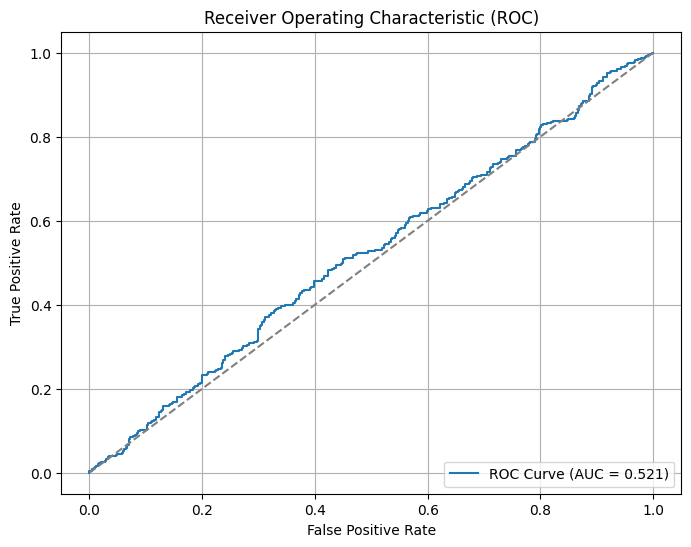

In [37]:
fpr, tpr, _ = roc_curve(y_val, y_val_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


This is very bad. The model even performs worse than random guessing. Now I am going to switch back to regression but I am going to use LSTM architecture.

In [38]:
window_size = 30

feature_columns = aapl_fe.columns.to_list()
X, y = create_multifeature_sequences(aapl_fe, feature_columns, window_size)

split_idx = int(len(X) * 0.8)

X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

input_shape = X_train.shape[1:]
aapl_fe

,Adj Close,adj_close_ret,adj_close_ret_st,high_low,log_volume,SMA_5,EMA_5,SMA_10,EMA_10,SMA_20,...,Bollinger_Lower,MACD_Line,MACD_Signal,Stoch_%K,Stoch_%D,ATR_14,lagged_15_ret,is_wednesday,SPY_ret,MSFT_ret
Dt,,,,,,,,,,,,,,,,,,,,,
2000-02-16,3.5464,-0.040969,-0.893843,6.0000,18.364762,3.54992,3.556888,3.49301,3.495297,3.405815,...,3.056320,0.075238,0.041406,-357.512353,-372.051812,108.442364,-0.018376,1,-0.014730,-0.009509
2000-02-17,3.5697,0.006570,0.040112,2.3750,18.097363,3.55846,3.561159,3.52894,3.508825,3.407950,...,3.054835,0.077218,0.048568,-357.420765,-357.283318,108.763571,-0.001694,0,-0.005172,0.020485
2000-02-18,3.4571,-0.031543,-0.759101,4.5000,17.882148,3.57400,3.526473,3.53904,3.499420,3.407855,...,3.054797,0.068907,0.052636,-407.807568,-374.246895,109.555593,-0.076149,0,-0.021468,-0.045798
2000-02-22,3.5367,0.023025,0.375653,10.2500,18.474923,3.56156,3.529882,3.53826,3.506198,3.419605,...,3.065782,0.067960,0.055701,-407.460546,-390.896293,110.391657,0.020899,0,-0.002541,-0.013147
2000-02-23,3.6125,0.021432,0.362700,8.0000,18.588521,3.54448,3.557421,3.54254,3.525526,3.425820,...,3.062679,0.072490,0.059059,-490.844677,-435.370930,111.566914,-0.033716,1,0.011808,0.004663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,111.3073,0.001978,0.028842,0.9355,16.472232,111.47162,111.196223,110.70836,110.446019,108.328325,...,102.884321,1.452375,1.075025,25.747002,31.684316,6.234743,0.003745,0,0.001464,-0.004878
2016-12-27,112.0142,0.006351,0.376098,1.3100,16.722242,111.59008,111.468882,111.08664,110.731143,108.600095,...,102.983873,1.495308,1.159081,33.034722,29.819494,6.260564,-0.007189,0,0.002481,0.000632
2016-12-28,111.5366,-0.004264,-0.702507,1.8170,16.855542,111.55378,111.491455,111.23662,110.877590,108.853240,...,103.184413,1.473805,1.222026,12.627747,23.803157,6.249421,0.007698,1,-0.008265,-0.004583


In [39]:
model9 = Sequential([
    LSTM(64, activation='tanh', input_shape=input_shape, return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

# Compile
optimizer = Adam(learning_rate=0.0005)  # Little faster learning rate since LSTM can stabilize better
model9.compile(optimizer=optimizer, loss='mse')

# Summary
model9.summary()

# Plot
plot_model(model9, show_shapes=True, dpi=70)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
history9 = model9.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


plotTrainLoss(history9)

c:\Users\gigan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 30, 64)         │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,001 (140.63 KB)

 Trainable params: 36,001 (140.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0742 - val_loss: 0.0211
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0061 - val_loss: 0.0246
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0034 - val_loss: 0.0206
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0024 - val_loss: 0.0203
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0018 - val_loss: 0.0204
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0012 - val_loss: 0.0196
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0011 - val_loss: 0.0174
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0011 - val_loss: 0.0194
Epoch 9/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 9.2233e-04 - val_loss: 0.0194
Epoch 10/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 9.1807e-04 - val_loss: 0.0207
Epoch 11/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 9.0172e-04 - val_loss: 0.0322
Epoch 12/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

### This looks like the model is improving and learning through epochs, and the loss is quite low, so I am going to choose this one as my final model.

In [40]:
modelName = "final_model"
model_path = os.path.join(".", modelName)

def saveModel(model, model_path): 
    """
    Save a model
    
    Parameters
    ----------
    model: a Keras model object
    model_path: String.  Relative path to a file in which the model will be stored
    
    
    Returns
    -------
    model_save_file: String.  Name of the file in which the model has been saved
        - this will be model_path with the proper file-extension added
    """
    
    model_save_file = model_path + '.keras'
      
    model.save(model_save_file)
    
    print(f"Model saved in {model_save_file:s}; submit with your assignment.")
    
    return model_save_file
   
def loadModel(model_save_file):
    model = tf.keras.models.load_model( model_save_file )
  
    return model

def MyModel(test_dir, model_save_file):
    # YOU MAY NOT change model after this statement !
    model = loadModel(model_save_file)
    
    # It should run model to create an array of predictions; we initialize it to the empty array for convenience
    predictions = []
    
    # We need to match your array of predictions with the examples you are predicting
    # The array below (ids) should have a one-to-one correspondence and identify the example your are predicting
    # For Bankruptcy: the Id column
    # For Stock prediction: the date on which you are making a prediction
    ids = []
    
    aapl_path = os.path.join(test_dir, "AAPL.csv")
    aapl = pd.read_csv(aapl_path, parse_dates=["Dt"])
    aapl.set_index("Dt", inplace=True)

    # Feature engineering
    aapl = extract_features(aapl)
    aapl = add_technical_indicators(aapl)
    aapl = add_custom_features(aapl)
    aapl = add_peer_returns(aapl,test_dir)

    feature_cols = [
        'Adj Close','adj_close_ret','adj_close_ret_st', 'high_low', 'log_volume',
        'SMA_5', 'EMA_5', 'SMA_10', 'EMA_10', 'SMA_20', 'EMA_20',
        'SMA_50', 'EMA_50', 'MACD_Line', 'MACD_Signal', 'RSI_14',
        'Bollinger_Upper', 'Bollinger_Lower', 'Stoch_%K', 'Stoch_%D', 'ATR_14',
        'lagged_15_ret', 'is_wednesday','SPY_ret','MSFT_ret'
    ]

    # === Sliding windows ===
    window = 30
    X_test = []
    idx = []

    df_feat = aapl[feature_cols].dropna()

    for i in range(window, len(df_feat)):
        X_test.append(df_feat.iloc[i-window:i].values)
        idx.append(df_feat.index[i])

    X_test = np.array(X_test)

    # === Predict ===
    predictions = model.predict(X_test).flatten().tolist()
    ids = [d.strftime("%Y-%m-%d") for d in idx]

    return predictions, ids

# Assign to variable my_model the model that is your final model (the one you will be evaluated on)
my_model = model9

model_save_file = saveModel(my_model, model_path)

Model saved in .\final_model.keras; submit with your assignment.


In [ ]:
holdout_dir = os.path.join(".", "Data", "holdout")
predicts = MyModel(holdout_dir, model_save_file)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


In [ ]:
print("Done")

Done
